In [3]:
import pandas as pd
import numpy as np
import torch
from torch.optim import Adam

import pyreadr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

from dataset import split_trainValTest
from trainer import train_AgeVae
from model import VAEAge, ElasticNet

In [4]:
data = pd.read_csv("./Data/Aging_data_combined_orthologs.csv")
datawNAN = data.fillna(0)
datawNAN = torch.Tensor(datawNAN.select_dtypes(include=['float64']).iloc[:, :-1].values)

In [6]:
batch_size = 64

data_size = datawNAN.shape[0]
validation_split = .2
test_split = .2
split_val = int(np.floor(validation_split * data_size))
split_test = int(np.floor(test_split * data_size))

indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices, test_indices = indices[split_val + split_test:], indices[:split_val], \
                                           indices[:split_val + split_test]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)


train_loader = torch.utils.data.DataLoader(datawNAN, batch_size=batch_size,
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(datawNAN, batch_size=batch_size,
                                          sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(datawNAN, batch_size=batch_size,
                                           sampler=test_sampler)

In [7]:
class VaeEncoder(nn.Module):
    def __init__(self, input_size: int, latent_size: int, down_channels: int):
        super().__init__()
        self._latent_size = latent_size
        self._input_size = input_size

        in_features = input_size
        x = (input_size // (2 * latent_size)) ** (1 / down_channels)

        #         print(x, input_size, 2*latent_size, 1/down_channels)

        modules = []
        for _ in range(down_channels - 1):
            out_features = int(in_features // x)
            modules += [
                torch.nn.Linear(in_features, out_features, bias=True),
                torch.nn.BatchNorm1d(out_features),
                torch.nn.LeakyReLU()
            ]
            in_features = out_features
        modules += [torch.nn.Linear(in_features, 2 * latent_size)]
        self._encoder = nn.Sequential(*modules)
        # print(self._encoder.parameters())

    def forward(self, vector):
        encoded = self._encoder(vector)
        assert encoded.shape[1] == self._latent_size * 2
        mu, log_sigma = torch.split(encoded, self._latent_size, dim=1)
        return mu, log_sigma


class VaeDecoder(nn.Module):
    def __init__(self, output_size: int, latent_size: int, up_channels: int):
        super().__init__()
        self._latent_size = latent_size
        self._output_size = output_size

        in_features = latent_size
        x = (output_size // (latent_size)) ** (1 / up_channels)

        #         print(x)
        modules = []

        for _ in range(up_channels - 1):
            out_features = int(in_features * x)
            modules += [
                torch.nn.Linear(in_features, out_features, bias=True),
                torch.nn.BatchNorm1d(out_features),
                torch.nn.LeakyReLU()
            ]
            in_features = out_features
        modules += [torch.nn.Linear(in_features, output_size)]
        self._decoder = nn.Sequential(*modules)

    def forward(self, embeddings):
#         embeddings = embeddings.reshape(*embeddings.shape, 1, 1)
        return self._decoder(embeddings)

In [8]:
class Age(nn.Module):
    def __init__(self, input_size: int, l1_lambda : int, l2_lambda: int):
        super().__init__()
        self._input_size = input_size

        self._model = torch.nn.Linear(input_size, 1, bias=True)
        self._relu = torch.nn.ReLU()
        self._norm = torch.nn.BatchNorm1d(1)
        
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda
        # print(self._encoder.parameters())

    def forward(self, vector):
        return self._relu(self._norm(self._model(vector))).flatten()
    
    def l1_reg(self):
        l1_norm = self._model.weight.abs().sum()

        return self.l1_lambda * l1_norm

    def l2_reg(self):
        l2_norm = self._model.weight.pow(2).sum()
        
        return self.l2_lambda * l2_norm

In [9]:
class VAE(nn.Module):
    def __init__(self, input_size, latent_size=10, down_channels=2, up_channels=2):
        super().__init__()

        self._encoder = VaeEncoder(input_size, latent_size, down_channels)
        self._decoder = VaeDecoder(input_size, latent_size, up_channels)

    def forward(self, x):
        mu, log_sigma = self._encoder(x)
        sigma = torch.exp(log_sigma)

        kld = 0.5 * (sigma + torch.square(mu) - log_sigma - 1)

        z = mu + torch.randn_like(sigma) * sigma
        x_pred = self._decoder(z)
        return x_pred, kld

    def encode(self, x):
        mu, log_sigma = self._encoder(x)
        sigma = torch.exp(log_sigma)

        return mu + torch.randn_like(sigma) * sigma

    def decode(self, z):
        return self._decoder(z)

In [12]:
class VAEAge(nn.Module):
    def __init__(self, input_size, l1_lambda : int, l2_lambda: int, latent_size=10, down_channels=2, up_channels=2):
        super().__init__()

        self._encoder = VaeEncoder(input_size, latent_size, down_channels)
        self._decoder = VaeDecoder(input_size, latent_size, up_channels)
        self._age = Age(latent_size, l1_lambda, l2_lambda)
        
    def forward(self, x):
        mu, log_sigma = self._encoder(x)
        sigma = torch.exp(log_sigma)

        kld = 0.5 * (sigma + torch.square(mu) - log_sigma - 1)

        z = mu + torch.randn_like(sigma) * sigma
        x_pred = self._decoder(z)
        age_pred = self._age(z)
        return x_pred, kld, age_pred

    def encode(self, x):
        mu, log_sigma = self._encoder(x)
        sigma = torch.exp(log_sigma)

        return mu + torch.randn_like(sigma) * sigma

    def decode(self, z):
        return self._decoder(z)
   
    def reg(self):
        return self._age.l1_reg() + self._age.l2_reg()

In [34]:
def train_vae(vae, dataloader, dataloader_val, dataset, batch_size):
    vae.cuda()

    epochs = 201
    vae_optim = Adam(vae.parameters(), lr=1e-4)

    #     test_imgs_1 = torch.cat([dataset[i].unsqueeze(0) for i in (0, 34, 76, 1509)])
    #     test_imgs_2 = torch.cat([dataset[i].unsqueeze(0) for i in (734, 123, 512, 3634)])

    for ep in range(epochs):
        total_batches = 0
        rec_loss_avg = 0
        kld_loss_avg = 0
        r2_avg = 0
        age_loss_avg = 0
        r2_age_avg = 0
        
        total_batches_val = 0
        rec_loss_avg_val = 0
        kld_loss_avg_val = 0
        r2_avg_val = 0
        age_loss_avg_val = 0
        r2_age_avg_val = 0
        
#                 if ep % 10 == 0:
#                     with torch.no_grad():
#                         indices = np.random.choice(dataset.shape[0], 10)
#                         z_1 = vae.encode(test_imgs_1.cuda())
#                         z_2 = vae.encode(test_imgs_2.cuda())
#                         x_int = []
#                         for i in range(9):
#                             z = (i * z_1 + (8 - i) * z_2) / 8
#                             x_int.append(vae.decode(z))
#                         x_int = torch.cat(x_int)
#                         visualise(x_int, rows=len(test_imgs_1))
#                         z_rand = torch.randn_like(z_1)
#                         x_int = vae.decode(z_rand)
#                         visualise(x_int, rows=len(test_imgs_1)//2)

        for i, batch in enumerate(dataloader):
            batch = batch[:, :-1]
            if len(batch) < batch_size:
                continue
            total_batches += 1
            x = batch.cuda()
            x_rec, kld = vae(x)
            img_elems = float(np.prod(list(batch.size())))
            kld_loss = kld.sum() / batch_size
            rec_loss = ((x_rec - x) ** 2).sum() / batch_size
            dis = ((x - torch.mean(x, dim = 0)) ** 2).sum() / batch_size
            r2 = 1 - rec_loss/dis
            loss = rec_loss + 0.1 * kld_loss  # https://openreview.net/forum?id=Sy2fzU9gl
            vae_optim.zero_grad()
            loss.backward()
            vae_optim.step()
            kld_loss_avg += kld_loss.item()
            rec_loss_avg += rec_loss.item()
            r2_avg += r2.item()


        print(
            f"Epoch {ep + 1} | MSE loss: {rec_loss_avg / total_batches} | R2: {r2_avg / total_batches} | KLD loss: {kld_loss_avg / total_batches}")

        with torch.no_grad():
            for i, batch in enumerate(dataloader_val):
                batch = batch[:, :-1]
                if len(batch) < batch_size:
                    continue
                total_batches_val += 1
                x = batch.cuda()
                x_rec, kld = vae(x)
                kld_loss = kld.sum() / batch_size
                rec_loss = ((x_rec - x) ** 2).sum() / batch_size
                dis = ((x - torch.mean(x, dim = 0)) ** 2).sum() / batch_size
                r2 = 1 - rec_loss/dis
                r2_avg_val += r2.item()
                kld_loss_avg_val += kld_loss.item()
                rec_loss_avg_val += rec_loss.item()

        print(
            f"Epoch {ep + 1} | MSE loss val: {rec_loss_avg_val / total_batches_val} | R2 val: {r2_avg_val / total_batches_val} | KLD loss val: {kld_loss_avg_val / total_batches_val}")

input_size = datawNAN.shape[1]
vae = VAE(input_size)
train_vae(vae, train_loader, val_loader, datawNAN, batch_size)

Epoch 1 | MSE loss: 14800.127115885416 | R2: -0.7012666861216227 | KLD loss: 27.332974036534626
Epoch 1 | MSE loss val: 12124.597290039062 | R2 val: -0.4353931099176407 | KLD loss val: 10.995737433433533
Epoch 2 | MSE loss: 10676.236775716146 | R2: -0.23593156784772873 | KLD loss: 13.8822633822759
Epoch 2 | MSE loss val: 8407.367736816406 | R2 val: -0.007257834076881409 | KLD loss val: 17.652472734451294
Epoch 3 | MSE loss: 7281.305114746094 | R2: 0.15634681781133017 | KLD loss: 22.07649366060893
Epoch 3 | MSE loss val: 6045.476623535156 | R2 val: 0.27802418917417526 | KLD loss val: 25.697219848632812
Epoch 4 | MSE loss: 5584.6755777994795 | R2: 0.3543919747074445 | KLD loss: 28.047183116277058
Epoch 4 | MSE loss val: 5092.2587890625 | R2 val: 0.3949764296412468 | KLD loss val: 29.880876064300537
Epoch 5 | MSE loss: 4861.284851074219 | R2: 0.4385102167725563 | KLD loss: 31.131099621454876
Epoch 5 | MSE loss val: 4735.021667480469 | R2 val: 0.4379062280058861 | KLD loss val: 31.87527847

Epoch 42 | MSE loss: 1747.8432922363281 | R2: 0.7981237694621086 | KLD loss: 34.16891233126322
Epoch 42 | MSE loss val: 1827.2602996826172 | R2 val: 0.7842071577906609 | KLD loss val: 33.781567335128784
Epoch 43 | MSE loss: 1690.9205373128254 | R2: 0.8046431317925453 | KLD loss: 34.11784919102987
Epoch 43 | MSE loss val: 1809.3771057128906 | R2 val: 0.7859459668397903 | KLD loss val: 33.75291872024536
Epoch 44 | MSE loss: 1705.917724609375 | R2: 0.8021906887491544 | KLD loss: 34.13192892074585
Epoch 44 | MSE loss val: 1855.6592407226562 | R2 val: 0.7776694819331169 | KLD loss val: 34.14693999290466
Epoch 45 | MSE loss: 1675.9888000488281 | R2: 0.805230937898159 | KLD loss: 34.0581222375234
Epoch 45 | MSE loss val: 1741.2891845703125 | R2 val: 0.7932376191020012 | KLD loss val: 33.875401973724365
Epoch 46 | MSE loss: 1699.132603963216 | R2: 0.8028065338730812 | KLD loss: 33.86424279212952
Epoch 46 | MSE loss val: 1767.6130828857422 | R2 val: 0.790556974709034 | KLD loss val: 33.57283830

Epoch 83 | MSE loss: 1193.5266189575195 | R2: 0.8616165444254875 | KLD loss: 33.53469785054525
Epoch 83 | MSE loss val: 1244.2284698486328 | R2 val: 0.8529789000749588 | KLD loss val: 33.3998327255249
Epoch 84 | MSE loss: 1215.560307820638 | R2: 0.8587183530131975 | KLD loss: 33.44331089655558
Epoch 84 | MSE loss val: 1278.9128952026367 | R2 val: 0.8480093702673912 | KLD loss val: 33.55629539489746
Epoch 85 | MSE loss: 1187.6583073933919 | R2: 0.8625798672437668 | KLD loss: 33.32519110043844
Epoch 85 | MSE loss val: 1227.42529296875 | R2 val: 0.854275144636631 | KLD loss val: 33.34611797332764
Epoch 86 | MSE loss: 1194.6748631795247 | R2: 0.8617649873097738 | KLD loss: 33.15433462460836
Epoch 86 | MSE loss val: 1271.4074096679688 | R2 val: 0.8477713167667389 | KLD loss val: 33.49406599998474
Epoch 87 | MSE loss: 1183.0528081258137 | R2: 0.8624781022469202 | KLD loss: 33.34422119458517
Epoch 87 | MSE loss val: 1266.2274627685547 | R2 val: 0.8485325276851654 | KLD loss val: 33.4956753253

Epoch 124 | MSE loss: 959.0205942789713 | R2: 0.8885008543729782 | KLD loss: 32.427401860555015
Epoch 124 | MSE loss val: 1037.7099914550781 | R2 val: 0.8768322765827179 | KLD loss val: 32.49610614776611
Epoch 125 | MSE loss: 957.050791422526 | R2: 0.8894207080205282 | KLD loss: 32.32766064008077
Epoch 125 | MSE loss val: 1092.0330810546875 | R2 val: 0.8684643805027008 | KLD loss val: 32.79609131813049
Epoch 126 | MSE loss: 961.4376220703125 | R2: 0.8882645045717558 | KLD loss: 32.549598375956215
Epoch 126 | MSE loss val: 1084.0175094604492 | R2 val: 0.8699541240930557 | KLD loss val: 32.43566179275513
Epoch 127 | MSE loss: 1005.7746505737305 | R2: 0.8828783705830574 | KLD loss: 32.3374191125234
Epoch 127 | MSE loss val: 1073.7738494873047 | R2 val: 0.871441051363945 | KLD loss val: 32.42018747329712
Epoch 128 | MSE loss: 959.8206939697266 | R2: 0.8887395809094111 | KLD loss: 32.25877253214518
Epoch 128 | MSE loss val: 1024.7217254638672 | R2 val: 0.8780704364180565 | KLD loss val: 32.

Epoch 165 | MSE loss: 857.8581771850586 | R2: 0.9008759210507075 | KLD loss: 32.01006658871969
Epoch 165 | MSE loss val: 895.178581237793 | R2 val: 0.8937245756387711 | KLD loss val: 32.11529183387756
Epoch 166 | MSE loss: 816.7125193277994 | R2: 0.905525637169679 | KLD loss: 32.05467748641968
Epoch 166 | MSE loss val: 953.1610794067383 | R2 val: 0.8862719163298607 | KLD loss val: 32.01462721824646
Epoch 167 | MSE loss: 850.7524210611979 | R2: 0.9015102783838908 | KLD loss: 31.913007736206055
Epoch 167 | MSE loss val: 958.8307495117188 | R2 val: 0.884918749332428 | KLD loss val: 32.134013652801514
Epoch 168 | MSE loss: 850.9592742919922 | R2: 0.9009291132291158 | KLD loss: 31.888032913208008
Epoch 168 | MSE loss val: 909.7245788574219 | R2 val: 0.8907221481204033 | KLD loss val: 32.189841508865356
Epoch 169 | MSE loss: 850.0767822265625 | R2: 0.9018797501921654 | KLD loss: 31.757522741953533
Epoch 169 | MSE loss val: 912.7622833251953 | R2 val: 0.8917545080184937 | KLD loss val: 31.908

In [24]:
def train_vae(vae, dataloader, dataloader_val, dataset, batch_size):
    vae.cuda()

    epochs = 201
    vae_optim = Adam(vae.parameters(), lr=1e-4)

    #     test_imgs_1 = torch.cat([dataset[i].unsqueeze(0) for i in (0, 34, 76, 1509)])
    #     test_imgs_2 = torch.cat([dataset[i].unsqueeze(0) for i in (734, 123, 512, 3634)])

    for ep in range(epochs):
        total_batches = 0
        rec_loss_avg = 0
        kld_loss_avg = 0
        r2_avg = 0
        age_loss_avg = 0
        age_reg_avg = 0
        
        total_batches_val = 0
        rec_loss_avg_val = 0
        kld_loss_avg_val = 0
        r2_avg_val = 0
        age_loss_avg_val = 0
        
#                 if ep % 10 == 0:
#                     with torch.no_grad():
#                         indices = np.random.choice(dataset.shape[0], 10)
#                         z_1 = vae.encode(test_imgs_1.cuda())
#                         z_2 = vae.encode(test_imgs_2.cuda())
#                         x_int = []
#                         for i in range(9):
#                             z = (i * z_1 + (8 - i) * z_2) / 8
#                             x_int.append(vae.decode(z))
#                         x_int = torch.cat(x_int)
#                         visualise(x_int, rows=len(test_imgs_1))
#                         z_rand = torch.randn_like(z_1)
#                         x_int = vae.decode(z_rand)
#                         visualise(x_int, rows=len(test_imgs_1)//2)

        for i, batch in enumerate(dataloader):
            x, age = batch[:, :-1].cuda(), batch[:, -1].cuda()
            if len(batch) < batch_size:
                continue
            total_batches += 1
            x_rec, kld, age_pred = vae(x)
            img_elems = float(np.prod(list(batch.size())))
            kld_loss = kld.sum() / batch_size
            rec_loss = ((x_rec - x) ** 2).sum() / batch_size
            dis = ((x - torch.mean(x, dim = 0)) ** 2).sum() / batch_size
            r2 = 1 - rec_loss/dis
            dis_age = ((age - torch.mean(age, dim = 0)) ** 2).sum() / len(age)
            age_loss2 = ((age_pred - age) ** 2).sum() / len(age)
            age_loss = torch.sqrt(age_loss2)
            r2_age = 1 - age_loss2 / dis_age
            if i == 0:
                print("age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape", age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape)
                print("age_pred[0], age[0], batch_size, age_loss", age_pred[0], age[0], batch_size, age_loss)
            age_reg = vae.reg()
            loss = rec_loss + 0.1 * kld_loss + 100 * (age_loss + age_reg) # https://openreview.net/forum?id=Sy2fzU9gl
            vae_optim.zero_grad()
            loss.backward()
            vae_optim.step()
            kld_loss_avg += kld_loss.item()
            rec_loss_avg += rec_loss.item()
            age_loss_avg += age_loss.item()
            age_reg_avg += age_reg.item()
            
            r2_avg += r2.item()


        print(
            f"Epoch {ep + 1} | Age r2: {r2_age_avg / total_batches} | Age loss: {age_loss_avg / total_batches} |Age reg: {age_reg_avg / total_batches} | MSE loss: {rec_loss_avg / total_batches} | R2: {r2_avg / total_batches} | KLD loss: {kld_loss_avg / total_batches}")
        
        
        with torch.no_grad():
            for i, batch in enumerate(dataloader_val):
                x, age = batch[:, :-1].cuda(), batch[:, -1].cuda()
                if len(batch) < batch_size:
                    continue
                total_batches_val += 1
                x_rec, kld, age_pred = vae(x)
                kld_loss = kld.sum() / batch_size
                rec_loss = ((x_rec - x) ** 2).sum() / batch_size
                dis = ((x - torch.mean(x, dim = 0)) ** 2).sum() / batch_size
                dis_age = ((age - torch.mean(age, dim = 0)) ** 2).sum() / len(age)
                age_loss2 = ((age_pred - age) ** 2).sum() / len(age)
                age_loss = torch.sqrt(age_loss2)
                r2_age = 1 - age_loss2 / dis_age
                r2 = 1 - rec_loss/dis
                r2_avg_val += r2.item()
                kld_loss_avg_val += kld_loss.item()
                rec_loss_avg_val += rec_loss.item()
                age_loss_avg_val += age_loss.item()

        print(
            f"Epoch {ep + 1} | Age r2: {r2_age_avg_val / total_batches_val} | Age loss val: {age_loss_avg_val / total_batches_val} | MSE loss val: {rec_loss_avg_val / total_batches_val} | R2 val: {r2_avg_val / total_batches_val} | KLD loss val: {kld_loss_avg_val / total_batches_val}")
l1_lambda, l2_lambda = 0.03, 0.01
input_size = datawNAN.shape[1] - 1
vae = VAEAge(input_size, l1_lambda, l2_lambda)
train_vae(vae, train_loader, val_loader, datawNAN, batch_size)

age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0., device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4605, device='cuda:0') 64 tensor(0.6403, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 1 | Age loss: 0.6040728787581126 |Age reg: 0.052381379529833794 | MSE loss: 14387.73046875 | R2: -0.6398647278547287 | KLD loss: 10.49432539443175
Epoch 1 | Age loss val: 0.5780250504612923 | MSE loss val: 11736.819946289062 | R2 val: -0.3547636717557907 | KLD loss val: 14.349763989448547
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0., device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 64 tensor(0.5302, device='cuda:0', grad_fn=<SqrtBack

Epoch 13 | Age loss: 0.3436570117870967 |Age reg: 0.05193926518162092 | MSE loss: 3228.77099609375 | R2: 0.6284179240465164 | KLD loss: 36.58082898457845
Epoch 13 | Age loss val: 0.3202463835477829 | MSE loss val: 3092.8836059570312 | R2 val: 0.6435147896409035 | KLD loss val: 36.20971155166626
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.6600, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3947, device='cuda:0') 64 tensor(0.3381, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 14 | Age loss: 0.31268007432421047 |Age reg: 0.05170559945205847 | MSE loss: 3122.3820597330728 | R2: 0.6396184538801511 | KLD loss: 35.776785691579185
Epoch 14 | Age loss val: 0.3042033948004246 | MSE loss val: 2985.910125732422 | R2 val: 0.654026135802269 | KLD loss val: 36.25774908065796
age_pred.shape, age.shape, batch.shape, x_rec.

Epoch 26 | Age loss: 0.27371813853581745 |Age reg: 0.05018241641422113 | MSE loss: 2187.5938975016275 | R2: 0.7485461980104446 | KLD loss: 33.24167092641195
Epoch 26 | Age loss val: 0.29738050512969494 | MSE loss val: 2224.3113708496094 | R2 val: 0.7409647703170776 | KLD loss val: 33.01116228103638
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2970, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.6319, device='cuda:0') 64 tensor(0.3128, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 27 | Age loss: 0.2747387904673815 |Age reg: 0.05008066430067023 | MSE loss: 2139.046590169271 | R2: 0.752848801513513 | KLD loss: 33.187127272288
Epoch 27 | Age loss val: 0.2773766554892063 | MSE loss val: 2157.6448364257812 | R2 val: 0.7499475032091141 | KLD loss val: 33.38648867607117
age_pred.shape, age.shape, batch.shape, x_rec.

Epoch 39 | Age loss: 0.28365947181979817 |Age reg: 0.04878659655029575 | MSE loss: 1751.3211720784504 | R2: 0.7988034834464391 | KLD loss: 33.565185149510704
Epoch 39 | Age loss val: 0.29406896233558655 | MSE loss val: 1785.0023651123047 | R2 val: 0.7937636896967888 | KLD loss val: 34.109347343444824
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.5542, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2078, device='cuda:0') 64 tensor(0.3283, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 40 | Age loss: 0.28316290241976577 |Age reg: 0.048688603875537716 | MSE loss: 1762.8567810058594 | R2: 0.7963040818770727 | KLD loss: 33.7002120812734
Epoch 40 | Age loss val: 0.3008175976574421 | MSE loss val: 1785.1727905273438 | R2 val: 0.7948554083704948 | KLD loss val: 33.361515045166016
age_pred.shape, age.shape, batch.shape

Epoch 52 | Age loss: 0.2895133414616187 |Age reg: 0.047507253320266805 | MSE loss: 1542.3332926432292 | R2: 0.8221909155448278 | KLD loss: 33.80256724357605
Epoch 52 | Age loss val: 0.30583613738417625 | MSE loss val: 1548.87548828125 | R2 val: 0.8219877704977989 | KLD loss val: 33.64929676055908
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0., device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0831, device='cuda:0') 64 tensor(0.3067, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 53 | Age loss: 0.29028804786503315 |Age reg: 0.04741228728865584 | MSE loss: 1555.5501047770183 | R2: 0.8208809494972229 | KLD loss: 33.492939949035645
Epoch 53 | Age loss val: 0.3138049766421318 | MSE loss val: 1607.9798431396484 | R2 val: 0.8121093884110451 | KLD loss val: 34.02893352508545
age_pred.shape, age.shape, batch.shape, x_rec.

Epoch 65 | Age loss: 0.2925156131386757 |Age reg: 0.04626015884180864 | MSE loss: 1367.151646931966 | R2: 0.8428591042757034 | KLD loss: 33.537327925364174
Epoch 65 | Age loss val: 0.3037174381315708 | MSE loss val: 1366.1393432617188 | R2 val: 0.843869999051094 | KLD loss val: 33.74083161354065
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4956, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5000, device='cuda:0') 64 tensor(0.2448, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 66 | Age loss: 0.2904515005648136 |Age reg: 0.046159697541346155 | MSE loss: 1353.7712961832683 | R2: 0.844068725903829 | KLD loss: 33.609617710113525
Epoch 66 | Age loss val: 0.31645385175943375 | MSE loss val: 1383.1006622314453 | R2 val: 0.8395086973905563 | KLD loss val: 33.84482288360596
age_pred.shape, age.shape, batch.shape, x_r

Epoch 78 | Age loss: 0.29148027176658314 |Age reg: 0.044908937687675156 | MSE loss: 1215.0984344482422 | R2: 0.8607751429080963 | KLD loss: 33.448691527048744
Epoch 78 | Age loss val: 0.30955155938863754 | MSE loss val: 1308.7612609863281 | R2 val: 0.8483670502901077 | KLD loss val: 33.902228355407715
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4883, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3989, device='cuda:0') 64 tensor(0.2736, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 79 | Age loss: 0.29218371336658794 |Age reg: 0.04479065785805384 | MSE loss: 1225.9270095825195 | R2: 0.8590390880902609 | KLD loss: 33.46957564353943
Epoch 79 | Age loss val: 0.32095587998628616 | MSE loss val: 1283.1541748046875 | R2 val: 0.8517138659954071 | KLD loss val: 33.90260338783264
age_pred.shape, age.shape, batch.shap

Epoch 91 | Age loss: 0.28927790311475593 |Age reg: 0.04370305842409531 | MSE loss: 1141.5136082967122 | R2: 0.8679574554165205 | KLD loss: 33.59540851910909
Epoch 91 | Age loss val: 0.30747605115175247 | MSE loss val: 1151.2531814575195 | R2 val: 0.8670764267444611 | KLD loss val: 33.81512975692749
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1904, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0307, device='cuda:0') 64 tensor(0.3310, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 92 | Age loss: 0.29043036078413326 |Age reg: 0.043612233052651085 | MSE loss: 1111.0455881754558 | R2: 0.8727080747485161 | KLD loss: 33.44119421641032
Epoch 92 | Age loss val: 0.315532423555851 | MSE loss val: 1202.461196899414 | R2 val: 0.8598634377121925 | KLD loss val: 33.95476317405701
age_pred.shape, age.shape, batch.shape, x_

Epoch 104 | Age loss: 0.28971251597007114 |Age reg: 0.042549896985292435 | MSE loss: 1054.5011393229167 | R2: 0.879196805258592 | KLD loss: 33.38294712702433
Epoch 104 | Age loss val: 0.310946062207222 | MSE loss val: 1091.8761596679688 | R2 val: 0.8737283647060394 | KLD loss val: 33.66877627372742
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2933, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4654, device='cuda:0') 64 tensor(0.2221, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 105 | Age loss: 0.28896067415674526 |Age reg: 0.0424658825310568 | MSE loss: 1067.772725423177 | R2: 0.8774163573980331 | KLD loss: 33.25153303146362
Epoch 105 | Age loss val: 0.31049323827028275 | MSE loss val: 1063.127555847168 | R2 val: 0.8770211413502693 | KLD loss val: 33.728665351867676
age_pred.shape, age.shape, batch.shape, 

Epoch 117 | Age loss: 0.29234787200887996 |Age reg: 0.041347339283674955 | MSE loss: 992.191640218099 | R2: 0.8862712929646174 | KLD loss: 32.94325486818949
Epoch 117 | Age loss val: 0.30419614166021347 | MSE loss val: 1030.4110107421875 | R2 val: 0.8802685290575027 | KLD loss val: 33.35057616233826
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0., device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 64 tensor(0.2762, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 118 | Age loss: 0.28698603125909966 |Age reg: 0.04125000691662232 | MSE loss: 1000.7785975138346 | R2: 0.8848255077997843 | KLD loss: 33.042500734329224
Epoch 118 | Age loss val: 0.3097683787345886 | MSE loss val: 1018.5004806518555 | R2 val: 0.8829110190272331 | KLD loss val: 33.155837059020996
age_pred.shape, age.shape, batch.shape, 

Epoch 130 | Age loss: 0.29244512630005676 |Age reg: 0.04007713201766213 | MSE loss: 946.6609141031901 | R2: 0.8911727691690127 | KLD loss: 33.0220894018809
Epoch 130 | Age loss val: 0.3141690194606781 | MSE loss val: 956.1385192871094 | R2 val: 0.8899211660027504 | KLD loss val: 33.13762187957764
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2246, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1316, device='cuda:0') 64 tensor(0.2940, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 131 | Age loss: 0.2897448154787223 |Age reg: 0.039976433695604406 | MSE loss: 937.3765869140625 | R2: 0.891583114862442 | KLD loss: 32.96953725814819
Epoch 131 | Age loss val: 0.3111216351389885 | MSE loss val: 983.5390853881836 | R2 val: 0.886312834918499 | KLD loss val: 33.151302337646484
age_pred.shape, age.shape, batch.shape, x_re

Epoch 143 | Age loss: 0.2920734876145919 |Age reg: 0.03878664535780748 | MSE loss: 891.1519877115885 | R2: 0.897490826745828 | KLD loss: 32.640567223230995
Epoch 143 | Age loss val: 0.31436026468873024 | MSE loss val: 940.8526763916016 | R2 val: 0.8906421437859535 | KLD loss val: 32.887311697006226
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0., device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 64 tensor(0.3304, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 144 | Age loss: 0.29388034840424854 |Age reg: 0.038682614297916494 | MSE loss: 902.8720550537109 | R2: 0.8965293516715368 | KLD loss: 32.43073527018229
Epoch 144 | Age loss val: 0.30923942476511 | MSE loss val: 918.359977722168 | R2 val: 0.8942616283893585 | KLD loss val: 32.741527795791626
age_pred.shape, age.shape, batch.shape, x_rec.

Epoch 156 | Age loss: 0.288064048315088 |Age reg: 0.03746670593197147 | MSE loss: 853.499989827474 | R2: 0.9022941216826439 | KLD loss: 32.42130335172018
Epoch 156 | Age loss val: 0.3127266801893711 | MSE loss val: 893.0806427001953 | R2 val: 0.8969530016183853 | KLD loss val: 32.761770486831665
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4129, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3823, device='cuda:0') 64 tensor(0.2798, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 157 | Age loss: 0.2939546046157678 |Age reg: 0.03736135565365354 | MSE loss: 869.781145731608 | R2: 0.8994960362712542 | KLD loss: 32.676056464513145
Epoch 157 | Age loss val: 0.31664784625172615 | MSE loss val: 942.700813293457 | R2 val: 0.8901591375470161 | KLD loss val: 32.752381801605225
age_pred.shape, age.shape, batch.shape, x_re

Epoch 169 | Age loss: 0.29318037008245784 |Age reg: 0.036153479324032865 | MSE loss: 836.5273056030273 | R2: 0.9041011532147726 | KLD loss: 32.18493763605753
Epoch 169 | Age loss val: 0.31736042723059654 | MSE loss val: 845.2845077514648 | R2 val: 0.9027243182063103 | KLD loss val: 32.52304172515869
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3680, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4238, device='cuda:0') 64 tensor(0.2587, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 170 | Age loss: 0.297553804392616 |Age reg: 0.036045847460627556 | MSE loss: 834.0734176635742 | R2: 0.9039747541149458 | KLD loss: 32.28268392880758
Epoch 170 | Age loss val: 0.30992192029953003 | MSE loss val: 875.9438171386719 | R2 val: 0.898517832159996 | KLD loss val: 32.482423067092896
age_pred.shape, age.shape, batch.shape, 

Epoch 182 | Age loss: 0.2928742791215579 |Age reg: 0.034819943054268755 | MSE loss: 806.2000096638998 | R2: 0.9073534682393074 | KLD loss: 32.19212142626444
Epoch 182 | Age loss val: 0.3151521012187004 | MSE loss val: 862.5070648193359 | R2 val: 0.9001693800091743 | KLD loss val: 32.61635875701904
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(1.0083, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 64 tensor(0.3099, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 183 | Age loss: 0.2945095586280028 |Age reg: 0.03472851309925318 | MSE loss: 813.1491673787435 | R2: 0.9067609086632729 | KLD loss: 32.08657248814901
Epoch 183 | Age loss val: 0.3102656789124012 | MSE loss val: 832.6973571777344 | R2 val: 0.903722457587719 | KLD loss val: 32.3706910610199
age_pred.shape, age.shape, batch.shape, x_rec

Epoch 195 | Age loss: 0.29254759040971595 |Age reg: 0.03355076521014174 | MSE loss: 815.5973383585612 | R2: 0.9056281720598539 | KLD loss: 32.32055942217509
Epoch 195 | Age loss val: 0.3165697976946831 | MSE loss val: 802.301643371582 | R2 val: 0.9075861424207687 | KLD loss val: 32.32865500450134
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0., device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 64 tensor(0.2881, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 196 | Age loss: 0.2933502768476804 |Age reg: 0.033460339065641165 | MSE loss: 799.8388977050781 | R2: 0.9074303905169169 | KLD loss: 32.152130762736
Epoch 196 | Age loss val: 0.31687165796756744 | MSE loss val: 792.8722152709961 | R2 val: 0.9080059081315994 | KLD loss val: 32.611902475357056
age_pred.shape, age.shape, batch.shape, x_rec.s

In [11]:
X_embedded = TSNE(n_components=2, init='random').fit_transform(datawNAN[:, :-1].numpy())

In [12]:
d = {'t-SNE1': X_embedded[:, 0], 't-SNE2': X_embedded[:, 1], 'Age': data["Age_rel_m"], 'GEO': data["GEO"], 'Tissue': data["Tissue"]}
df = pd.DataFrame(data=d)

In [13]:
data.head()

,Unnamed: 0,22290,19241,22764,26900,20592,21674,170835,245522,223775,...,98733,20713,69719,71583,Age_rel_m,Age_m,GEO,Sex,Tissue,Species
0,GSM68912,-0.247323,2.507661,-0.541452,1.350328,-0.243283,-0.161073,1.620147,-0.473716,0.569714,...,0.065406,-1.089505,0.354001,0.172595,0.458333,22.0,GSE3150,Male,Liver,Mouse
1,GSM68913,-0.886874,2.376398,0.089364,-1.845986,-0.429977,-0.120847,1.413098,-0.240960,1.526477,...,-0.030337,-0.990064,0.220329,0.108677,0.458333,22.0,GSE3150,Male,Liver,Mouse
2,GSM68914,-0.425477,2.486357,-0.267903,1.091088,-0.304483,-0.508611,1.648069,0.230987,0.658745,...,-0.044280,-0.505998,0.217979,-0.702106,0.458333,22.0,GSE3150,Male,Liver,Mouse
3,GSM68915,-0.109844,2.485793,-0.257505,1.092448,-0.376999,-0.164930,1.415539,-0.020269,0.987971,...,-0.675073,-0.438833,0.300332,0.066519,0.458333,22.0,GSE3150,Male,Liver,Mouse
4,GSM68916,-0.113013,2.483457,-0.663475,1.117652,-0.534237,-0.090691,1.659320,0.066766,0.916895,...,-0.417904,-0.944047,0.190206,-0.478423,0.458333,22.0,GSE3150,Male,Liver,Mouse


In [1]:
sns.scatterplot(data=df, x="t-SNE1", y="t-SNE2", hue="Age")
sns.set(rc={'figure.figsize':(5.7,10.27)})

NameError: name 'sns' is not defined

In [25]:
x = vae.encode(datawNAN[:, :-1].cuda())
x.shape

torch.Size([2609, 10])

In [26]:
_, _, age = vae.forward(datawNAN[:, :-1].cuda())
print([x for x in vae._age._model.parameters()])

[Parameter containing:
tensor([[ 0.2362, -0.1424,  0.2028, -0.1598, -0.0237, -0.0869, -0.0434, -0.0421,
         -0.0183,  0.0877]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([0.0337], device='cuda:0', requires_grad=True)]


In [17]:
max(age), min(age)

(tensor(0.7540, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0., device='cuda:0', grad_fn=<UnbindBackward0>))

In [18]:
vae_embedded = TSNE(n_components=2, init='random').fit_transform(x.cpu().detach().numpy())

In [19]:
d_vae = {'t-SNE1': vae_embedded[:, 0], 't-SNE2': vae_embedded[:, 1], 'Age': data["Age_rel_m"], 'Tissue': data["Tissue"]}
df_vae = pd.DataFrame(data=d_vae)

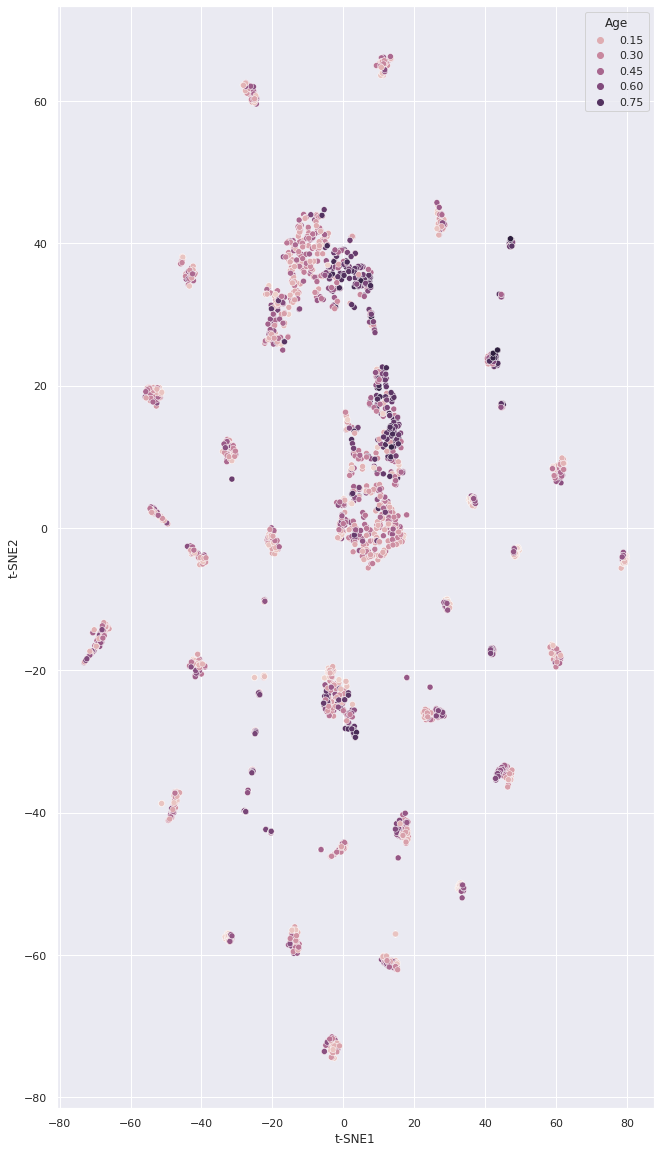

In [20]:
sns.scatterplot(data=df_vae, x="t-SNE1", y="t-SNE2", hue="Age")
sns.set(rc={'figure.figsize':(10.7,20.27)})

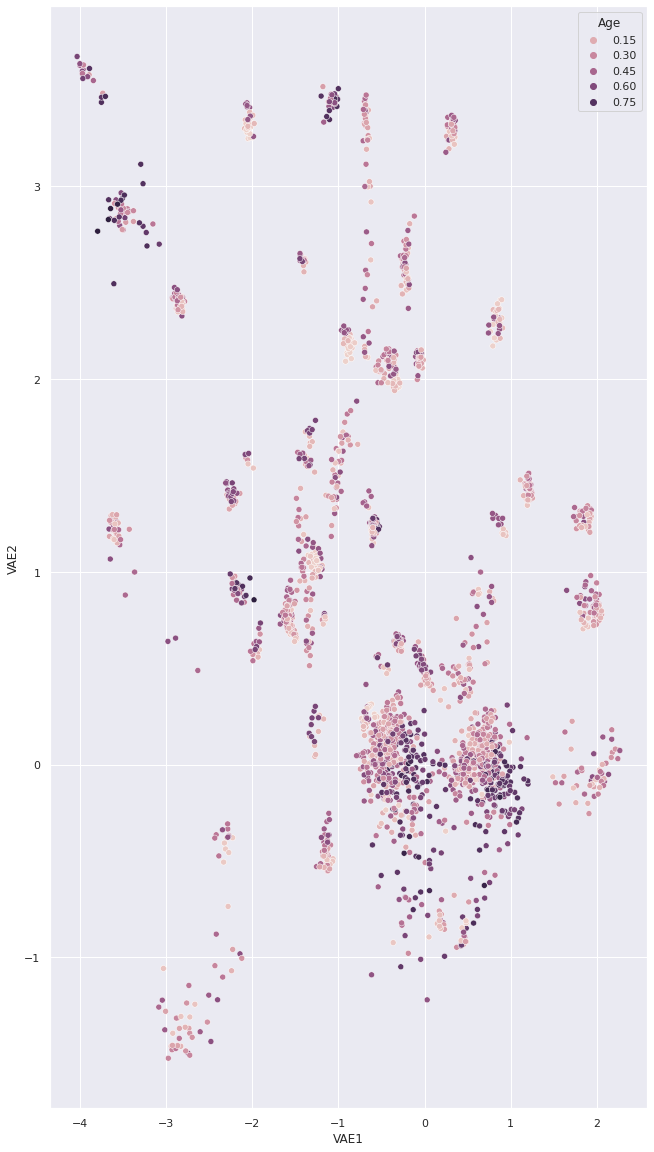

In [21]:
vae1 = {'VAE1': x.cpu().detach()[:, 0], 'VAE2': x.cpu().detach()[:, 4], 'Age': data["Age_rel_m"]}
df_vae1 = pd.DataFrame(data=vae1)
sns.scatterplot(data=df_vae1, x="VAE1", y="VAE2", hue="Age")
sns.set(rc={'figure.figsize':(10.7,20.27)})

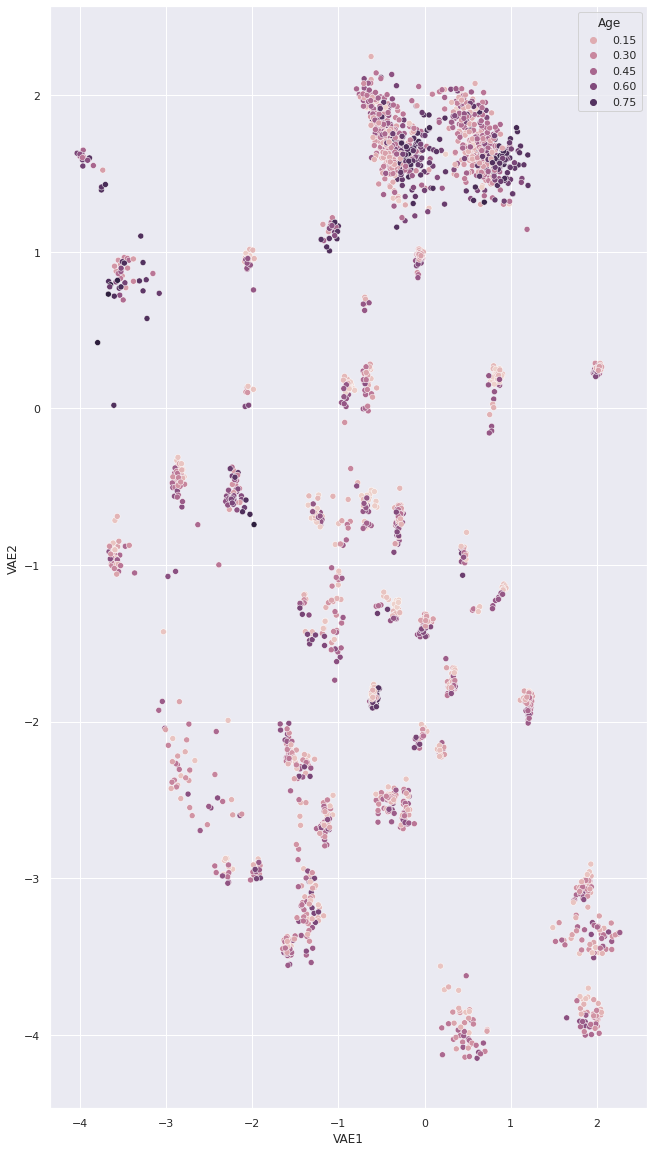

In [22]:
vae1 = {'VAE1': x.cpu().detach()[:, 0], 'VAE2': x.cpu().detach()[:, 6], 'Age': data["Age_rel_m"]}
df_vae1 = pd.DataFrame(data=vae1)
sns.scatterplot(data=df_vae1, x="VAE1", y="VAE2", hue="Age")
sns.set(rc={'figure.figsize':(10.7,20.27)})

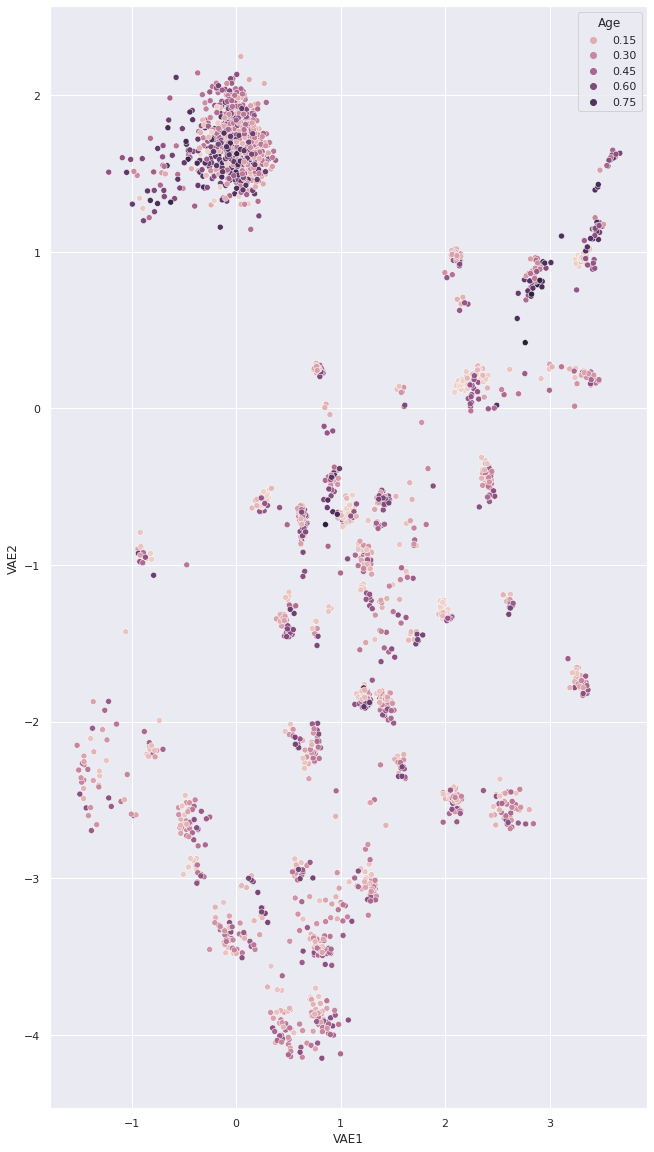

In [23]:
vae1 = {'VAE1': x.cpu().detach()[:, 4], 'VAE2': x.cpu().detach()[:, 6], 'Age': data["Age_rel_m"]}
df_vae1 = pd.DataFrame(data=vae1)
sns.scatterplot(data=df_vae1, x="VAE1", y="VAE2", hue="Age")
sns.set(rc={'figure.figsize':(10.7,20.27)})

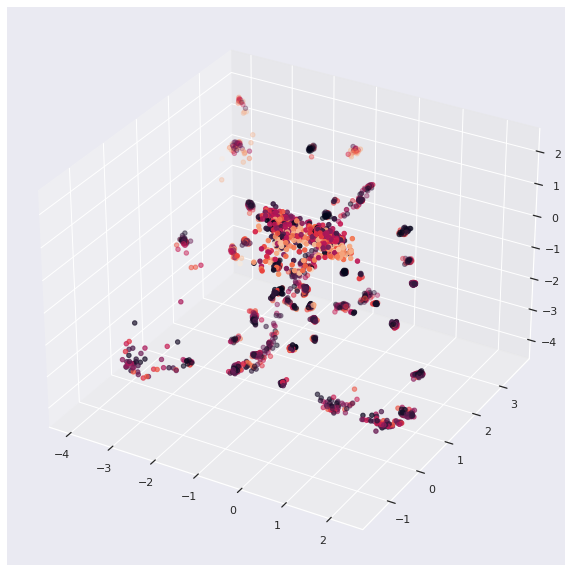

In [24]:
fig = plt.figure(figsize = [10, 20])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs = x.cpu().detach()[:, 0], ys = x.cpu().detach()[:, 4], zs = x.cpu().detach()[:, 6], c = data["Age_rel_m"])

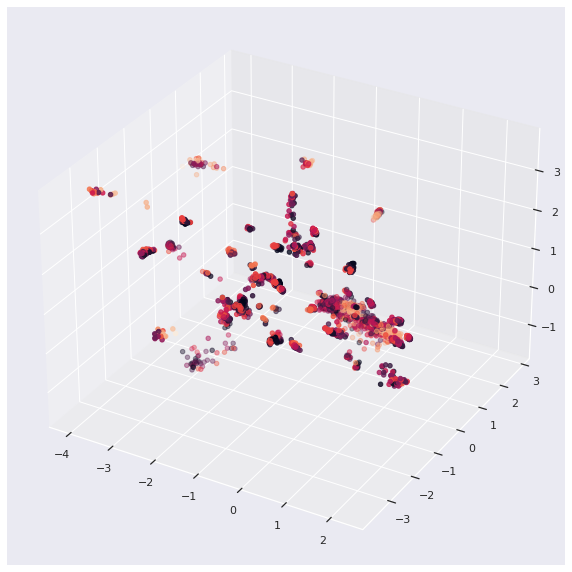

In [25]:
fig = plt.figure(figsize = [10, 20])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs = x.cpu().detach()[:, 0], ys = x.cpu().detach()[:, 3], zs = x.cpu().detach()[:, 4], c = data["Age_rel_m"])

In [27]:
corr = np.concatenate([x.cpu().detach().numpy(), datawNAN[:, -1].reshape((-1, 1)).cpu().detach().numpy()], axis = 1)
corr.shape

(2609, 11)

In [28]:
corrcoef = np.corrcoef(corr, rowvar = False)
corrcoef.shape

(11, 11)

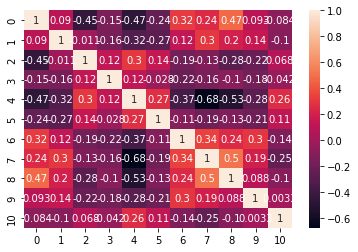

In [29]:
ax = sns.heatmap(corrcoef, annot=True)

In [3]:
data.select_dtypes(include=['float64']).columns

Index(['22290', '19241', '22764', '26900', '20592', '21674', '170835',
       '245522', '223775', '29812',
       ...
       '21355', '74246', '245944', '70025', '98733', '20713', '69719', '71583',
       'Age_rel_m', 'Age_m'],
      dtype='object', length=15813)

In [4]:
data.head()

,Unnamed: 0,22290,19241,22764,26900,20592,21674,170835,245522,223775,...,98733,20713,69719,71583,Age_rel_m,Age_m,GEO,Sex,Tissue,Species
0,GSM68912,-0.247323,2.507661,-0.541452,1.350328,-0.243283,-0.161073,1.620147,-0.473716,0.569714,...,0.065406,-1.089505,0.354001,0.172595,0.458333,22.0,GSE3150,Male,Liver,Mouse
1,GSM68913,-0.886874,2.376398,0.089364,-1.845986,-0.429977,-0.120847,1.413098,-0.240960,1.526477,...,-0.030337,-0.990064,0.220329,0.108677,0.458333,22.0,GSE3150,Male,Liver,Mouse
2,GSM68914,-0.425477,2.486357,-0.267903,1.091088,-0.304483,-0.508611,1.648069,0.230987,0.658745,...,-0.044280,-0.505998,0.217979,-0.702106,0.458333,22.0,GSE3150,Male,Liver,Mouse
3,GSM68915,-0.109844,2.485793,-0.257505,1.092448,-0.376999,-0.164930,1.415539,-0.020269,0.987971,...,-0.675073,-0.438833,0.300332,0.066519,0.458333,22.0,GSE3150,Male,Liver,Mouse
4,GSM68916,-0.113013,2.483457,-0.663475,1.117652,-0.534237,-0.090691,1.659320,0.066766,0.916895,...,-0.417904,-0.944047,0.190206,-0.478423,0.458333,22.0,GSE3150,Male,Liver,Mouse


In [5]:
ann = pd.read_csv("./Data/Annotation_numeric_NEW.csv")

In [6]:
ann.head()

,Unnamed: 0,ID,Species,GEO,Tissue,Sex,Unit,Unit_days,Unit_months,Max_lifespan_years,Max_lifespan_months
0,Mouse_GSE3150_Liver_Male,Mouse_GSE3150_Liver_Male,Mouse,GSE3150,Liver,Male,months,30,1.000000,4.0,48.0
1,Mouse_GSE6591_Lung_Male_DBA2J,Mouse_GSE6591_Lung_Male_DBA2J,Mouse,GSE6591,Lung,Male,months,30,1.000000,4.0,48.0
2,Mouse_GSE6591_Lung_Male_C57BL6J,Mouse_GSE6591_Lung_Male_C57BL6J,Mouse,GSE6591,Lung,Male,months,30,1.000000,4.0,48.0
3,Mouse_GSE74463_Kidney_Female,Mouse_GSE74463_Kidney_Female,Mouse,GSE74463,Kidney,Female,weeks,7,0.233333,4.0,48.0
4,Mouse_GSE11291_Heart_Male,Mouse_GSE11291_Heart_Male,Mouse,GSE11291,Heart,Male,months,30,1.000000,4.0,48.0


In [7]:
print(len(ann["ID"]), len(ann["ID"].unique()))

85 85


In [8]:
ann["Tissue"].unique()

array(['Liver', 'Lung', 'Kidney', 'Heart', 'Muscle', 'Brain', 'BAT',
       'SCAT', 'WBC', 'Small Intestine', 'Spleen', 'Pancreas', 'Bone',
       'GAT', 'MAT', 'Skin', 'Marrow', 'DermalFibroblasts'], dtype=object)

In [9]:
print([(x, len(ann[ann["Species"] == x])) for x in ann["Species"].unique()])

[('Mouse', 50), ('Rat', 19), ('Human', 16)]


In [10]:
print(*[(x, ann[ann["Species"] == x]["Tissue"].unique()) for x in ann["Species"].unique()])

('Mouse', array(['Liver', 'Lung', 'Kidney', 'Heart', 'Muscle', 'Brain', 'BAT',
       'SCAT', 'WBC', 'Small Intestine', 'Spleen', 'Pancreas', 'Bone',
       'GAT', 'MAT', 'Skin', 'Marrow'], dtype=object)) ('Rat', array(['Liver', 'Brain', 'Heart', 'Kidney', 'Lung', 'Muscle'],
      dtype=object)) ('Human', array(['Brain', 'Muscle', 'DermalFibroblasts'], dtype=object))


In [11]:
print(*[ann[ann["Species"] == x]["Max_lifespan_months"].unique() for x in ann["Species"].unique()])

[48.] [45.6] [1464.]


In [12]:
print(*[(x, len(data[data["Species"] == x]["Age_m"].unique()), 
        min(data[data["Species"] == x]["Age_m"].unique()),
        max(data[data["Species"] == x]["Age_m"].unique()),
        len(data[data["Species"] == x]["Age_rel_m"].unique()), 
        min(data[data["Species"] == x]["Age_rel_m"].unique()),
        max(data[data["Species"] == x]["Age_rel_m"].unique())) for x in data["Species"].unique()])

('Mouse', 29, 1.0, 32.0, 29, 0.0208333333333333, 0.666666666666667) ('Rat', 12, 0.466666666666666, 27.0, 12, 0.010233918128655, 0.592105263157895) ('Human', 170, 12.0, 1289.66666666667, 170, 0.0081967213114754, 0.880919854280512)
